In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, utils, models
from tensorflow.keras.datasets import mnist


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train.shape



11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
x_train_scaled = x_train.astype('float32') / 255.
x_test_scaled = x_test.astype('float32') / 255.

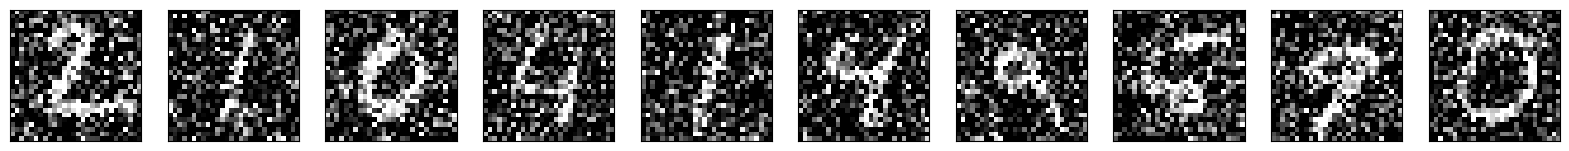

In [4]:

x_train_scaled = np.reshape(x_train_scaled, (len(x_train_scaled), 28, 28, 1))
x_test_scaled = np.reshape(x_test_scaled, (len(x_test_scaled), 28, 28, 1))
noise_factor = 0.5
x_train_noisy = x_train_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_scaled.shape)
x_test_noisy = x_test_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_scaled.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
input_img = keras.Input(shape=(28, 28, 1))

x=layers.Conv2D(16,(5,5),activation='relu',padding='same')(input_img)
x=layers.MaxPooling2D((2,2),padding='same')(x)
x=layers.Conv2D(4,(3,3),activation='relu',padding='same')(x)
x=layers.MaxPooling2D((2,2),padding='same')(x)
x=layers.Conv2D(4,(3,3),activation='relu',padding='same')(x)
x=layers.MaxPooling2D((2,2),padding='same')(x)
x=layers.Conv2D(8,(7,7),activation='relu',padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x=layers.Conv2D(4,(3,3),activation='relu',padding='same')(encoded)
x=layers.UpSampling2D((2,2))(x)
x=layers.Conv2D(4,(3,3),activation='relu',padding='same')(x)
x=layers.UpSampling2D((2,2))(x)
x=layers.Conv2D(8,(5,5),activation='relu',padding='same')(x)
x=layers.UpSampling2D((2,2))(x)
x=layers.Conv2D(16,(5,5),activation='relu',padding='same')(x)
x=layers.UpSampling2D((2,2))(x)
x=layers.Conv2D(16,(5,5),activation='relu')(x)
x=layers.UpSampling2D((1,1))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 4)         580       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 4)           148   

Epoch 1/3
235/235 [==============================] - 206s 865ms/step - loss: 0.2911 - val_loss: 0.2322
Epoch 2/3
235/235 [==============================] - 198s 841ms/step - loss: 0.2183 - val_loss: 0.2014
Epoch 3/3
313/313 [==============================] - 11s 35ms/step


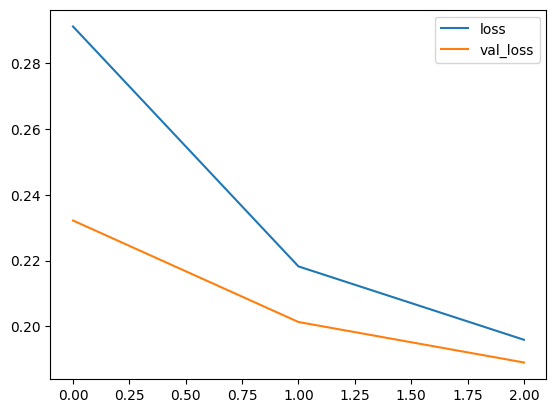

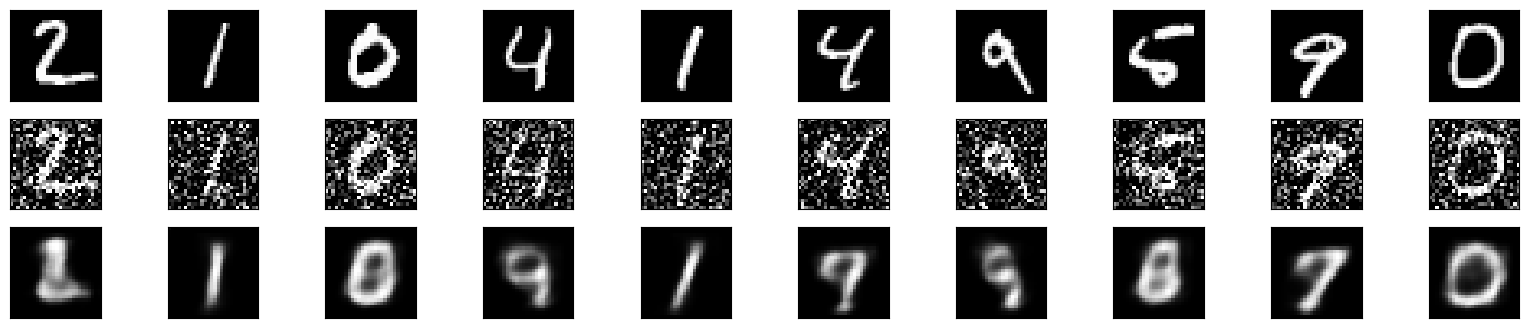

In [6]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train_scaled,
                epochs=3,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_scaled))
metrics = pd.DataFrame(autoencoder.history.history)
metrics[['loss','val_loss']].plot()
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_scaled[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()